In [1]:
# food_keras_training.py
# Run: python food_keras_training.py
import os, json, math, pathlib
from collections import Counter

import numpy as np
import tensorflow as tf
from tensorflow import keras

# -------------------
# Basic config
# -------------------
DATA_DIR = pathlib.Path("dataset_split")  # change if needed
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"

# We'll load images as 256x256, then center-crop to 224 to preserve aspect ratio
LOAD_SIZE = (256, 256)
NET_SIZE  = (224, 224)   # EfficientNetB0 expected resolution

BATCH    = 32
EPOCHS   = 25
SEED     = 1337

MODEL_OUT     = "food_efficientnet_b0.keras"
CLASSMAP_JSON = "class_names.json"

# Repro (best-effort)
tf.keras.utils.set_random_seed(SEED)
# Uncomment for strict determinism (slower):
# tf.config.experimental.enable_op_determinism = True

# Disable mixed precision for CPU training
MIXED = False

# -------------------
# Datasets (force RGB; mixed sizes OK)
# -------------------
def make_ds(dir_path, shuffle=True):
    return tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="int",
        image_size=LOAD_SIZE,    # Resize loader output to 256x256 (no AR preservation here)
        batch_size=BATCH,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb",        # <-- ensure 3 channels for ImageNet weights
    )

train_ds = make_ds(TRAIN_DIR, shuffle=True)
val_ds   = make_ds(VAL_DIR,   shuffle=False)
test_ds  = make_ds(TEST_DIR,  shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)

with open(CLASSMAP_JSON, "w") as f:
    json.dump(class_names, f, indent=2)

# Cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# -------------------
# Class weights for imbalance
# -------------------
def count_per_class(root_dir: pathlib.Path):
    cnt = Counter()
    for i, cname in enumerate(class_names):
        cnt[i] = len(list((root_dir / cname).glob("*")))
    return cnt

train_counts = count_per_class(TRAIN_DIR)
total = sum(train_counts.values())

# inverse-frequency, softened with sqrt to avoid overcompensating
class_weight = {i: math.sqrt(total / (num_classes * c)) for i, c in train_counts.items()}

print("Class weights (sqrt inv-freq):")
for i, w in class_weight.items():
    print(f"  {class_names[i]:30s}: {w:.3f}  (n={train_counts[i]})")
    
# -------------------
# Model
#   Load 256x256 -> CenterCrop(224) to preserve AR -> Augment -> Preprocess -> EfficientNetB0
# -------------------
pre_resize = keras.Sequential([
    keras.layers.CenterCrop(NET_SIZE[0], NET_SIZE[1]),  # from 256x256 -> 224x224, AR preserved due to prior uniform resize + crop
], name="center_crop_224")

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
], name="augmentation")

# Explicit RGB input: shape matches dataset output (256x256x3) -> then we crop to 224
inputs = keras.Input(shape=(LOAD_SIZE[0], LOAD_SIZE[1], 3), name="input_rgb_256")

x = pre_resize(inputs)  # (224,224,3)
x = tf.cast(x, tf.float32)  # Ensure float32 for augmentation
x = data_augmentation(x)
x = keras.applications.efficientnet.preprocess_input(x)

base = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
)
base.trainable = False  # phase 1: freeze

x = base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

# keep final layer float32 if mixed precision is on
dtype_out = "float32" if MIXED else None
outputs = keras.layers.Dense(num_classes, activation="softmax", dtype=dtype_out)(x)

model = keras.Model(inputs, outputs, name="food_efficientnet_b0")

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),  # no label_smoothing
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3"),
    ],
)

model.summary()

# -------------------
# Callbacks
# -------------------
ckpt = keras.callbacks.ModelCheckpoint(
    MODEL_OUT, monitor="val_acc", mode="max", save_best_only=True, verbose=1
)
early = keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True, verbose=1
)
reduce = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

# -------------------
# Train (single phase)
# -------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, early, reduce],
    class_weight=class_weight,
)

# -------------------
# Evaluate on test
# -------------------
print("\nEvaluating on test set...")
test_metrics = model.evaluate(test_ds, verbose=2)
for name, val in zip(model.metrics_names, test_metrics):
    print(f"{name}: {val:.4f}")

# -------------------
# Confusion matrix & per-class report
# -------------------
y_true, y_pred = [], []
for batch_imgs, batch_labels in test_ds:
    probs = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(batch_labels.numpy().tolist())

try:
    from sklearn.metrics import confusion_matrix, classification_report

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    # Simple text matrix to avoid plotting deps
    def format_cm(cm):
        lines = []
        for r in cm:
            lines.append(" ".join(f"{v:4d}" for v in r))
        return "\n".join(lines)

    print("Confusion matrix (rows=true, cols=pred):")
    print(format_cm(cm))

except Exception as e:
    print("\n[Info] scikit-learn not available; skipping confusion matrix/report.")
    print(f"Details: {e}")

# -------------------
# Single-image prediction helper
# -------------------
def predict_one(image_path: str):
    """
    Returns (label, probability) for a single image path.
    Applies the same 256->center-crop(224)->preprocess pipeline.
    """
    img = tf.keras.utils.load_img(image_path, target_size=LOAD_SIZE, color_mode="rgb")
    x = tf.keras.utils.img_to_array(img)
    # Center-crop to 224x224 (replicate the model's pre_resize)
    h, w = x.shape[:2]
    top = (h - NET_SIZE[0]) // 2
    left = (w - NET_SIZE[1]) // 2
    x = x[top:top+NET_SIZE[0], left:left+NET_SIZE[1], :]
    x = np.expand_dims(x, 0)
    x = keras.applications.efficientnet.preprocess_input(x)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return class_names[idx], float(probs[idx])

# Example:
# lbl, p = predict_one("some_food.jpg")
# print(lbl, p)



Found 8479 files belonging to 20 classes.
Found 8479 files belonging to 20 classes.
Found 2745 files belonging to 20 classes.
Found 2745 files belonging to 20 classes.
Found 2826 files belonging to 20 classes.
Found 2826 files belonging to 20 classes.
Class weights (sqrt inv-freq):
  Braised Chicken Feet          : 1.235  (n=278)
  Braised Pig Trotters          : 1.211  (n=289)
  Braised Pork                  : 0.657  (n=983)
  Dry Pot Cauliflower           : 1.267  (n=264)
  Egg Drop Soup                 : 1.235  (n=278)
  Fish Flavored Shredded Pork   : 0.703  (n=859)
  Fish Head Tofu Soup           : 1.294  (n=253)
  Fragrant Soy-sauced Eggplant  : 1.297  (n=252)
  Glass Noodles with Minced Pork: 1.270  (n=263)
  Hot and Sour Lotus Root Slices: 1.267  (n=264)
  Kung Pao Chicken              : 0.705  (n=854)
  Salted Egg Yolk Pumpkin       : 1.272  (n=262)
  Scallion Oil Noodles          : 1.215  (n=287)
  Spicy Chongqing Hotpot        : 1.203  (n=293)
  Spicy Crab                  

Found 2826 files belonging to 20 classes.

Classification Report:

                                precision    recall  f1-score   support

          Braised Chicken Feet      0.983     0.992     0.988       120
          Braised Pig Trotters      1.000     0.992     0.996       118
                  Braised Pork      0.962     0.977     0.969       307
           Dry Pot Cauliflower      0.965     0.976     0.970        84
                 Egg Drop Soup      0.974     0.991     0.983       114
   Fish Flavored Shredded Pork      0.996     0.955     0.975       267
           Fish Head Tofu Soup      1.000     0.987     0.994        78
  Fragrant Soy-sauced Eggplant      0.875     0.921     0.897        76
Glass Noodles with Minced Pork      0.976     0.988     0.982        83
Hot and Sour Lotus Root Slices      0.991     0.991     0.991       107
              Kung Pao Chicken      0.981     0.981     0.981       266
       Salted Egg Yolk Pumpkin      0.988     1.000     0.994       

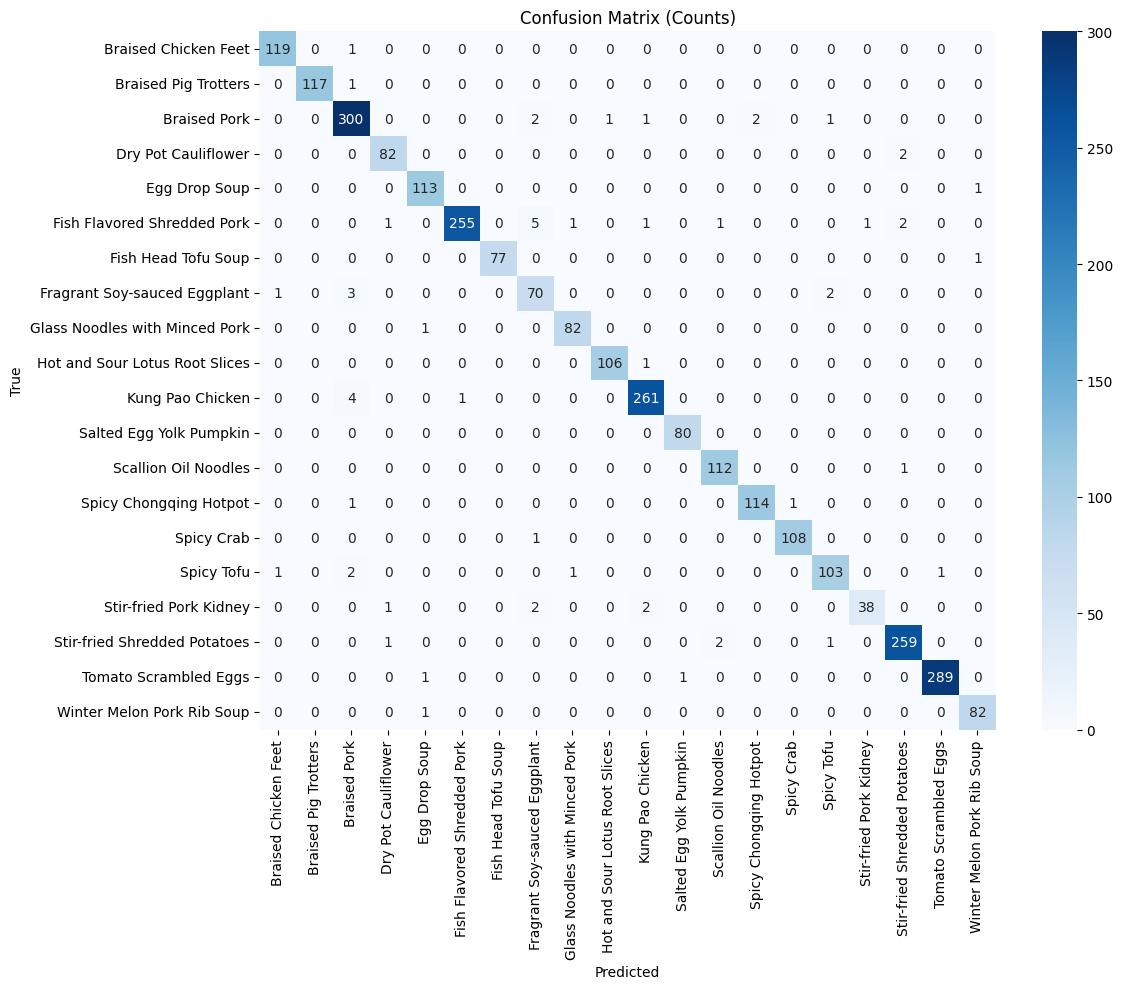

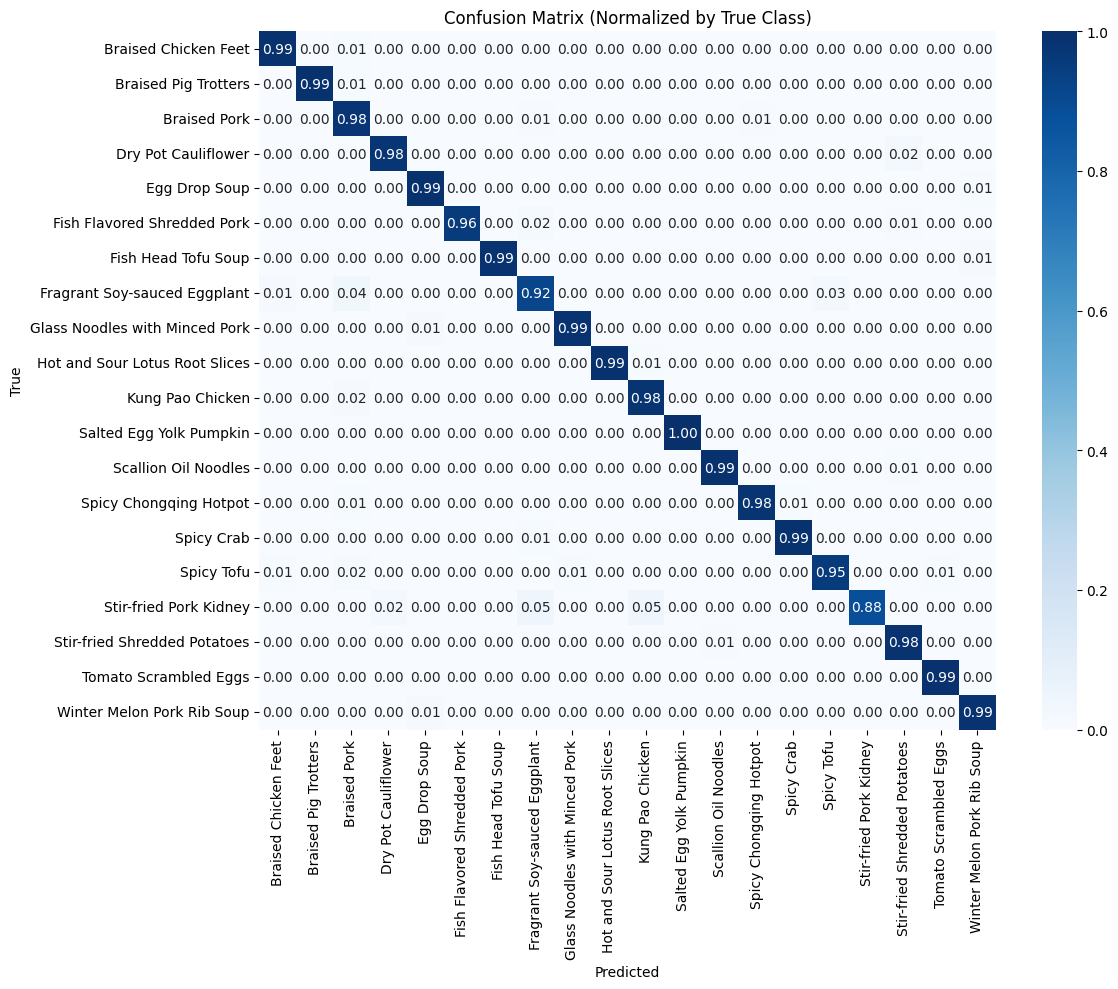

In [ ]:
# Confusion_matrix_from_saved.py
import json, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Load model + class names
# -------------------------
loaded = keras.models.load_model("food_efficientnet_b0.keras")

with open("class_names.json", "r") as f:
    class_names = json.load(f)
num_classes = len(class_names)

# Wrap: accept 224×224 and resize to 256×256 for the saved model
inputs224 = keras.Input(shape=(224, 224, 3))
x = keras.layers.Resizing(256, 256, interpolation="bilinear")(inputs224)
outputs = loaded(x)
model = keras.Model(inputs224, outputs, name="wrapped_food_model")

# -------------------------
# 2. Build test dataset (224×224 RGB)
# -------------------------
DATA_DIR = pathlib.Path("dataset_split")
TEST_DIR = DATA_DIR / "test"
IMG_SIZE = (224, 224)
BATCH = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
    color_mode="rgb",
)

# -------------------------
# 3. Get predictions
# -------------------------
y_true, y_pred = [], []
for batch_imgs, batch_labels in test_ds:
    probs = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(batch_labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------------------------
# 4. Classification report
# -------------------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# -------------------------
# 5. Confusion matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

# Normalized (row-wise) confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            vmin=0.0, vmax=1.0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Normalized by True Class)")
plt.tight_layout()
plt.show()


In [3]:
import json, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report

# --- Load model and class names ---
loaded = keras.models.load_model("food_efficientnet_b0.keras")
with open("class_names.json", "r") as f:
    class_names = json.load(f)

# Wrap so we can feed 224x224
inputs224 = keras.Input(shape=(224, 224, 3))
x = keras.layers.Resizing(256, 256, interpolation="bilinear")(inputs224)
outputs = loaded(x)
model = keras.Model(inputs224, outputs)

# --- Build test dataset: load as RGB to avoid GIF channel issues ---
DATA_DIR = pathlib.Path("dataset_split")
TEST_DIR = DATA_DIR / "test"
IMG_SIZE = (224, 224)
BATCH = 32

test_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
    color_mode="rgb",           # important: load as RGB
)

# --- Convert RGB -> Grayscale -> back to 3 channels (gray triplet) ---
def rgb_to_gray_triplet(x, y):
    g1 = tf.image.rgb_to_grayscale(x)      # (B,H,W,1)
    g3 = tf.image.grayscale_to_rgb(g1)     # (B,H,W,3) — still grayscale (no color info)
    return g3, y

test_ds_gray3 = test_ds_rgb.map(rgb_to_gray_triplet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_gray3 = test_ds_gray3.prefetch(tf.data.AUTOTUNE)

# --- Evaluate on grayscale (no color info) ---
y_true, y_pred = [], []
for batch_imgs, batch_labels in test_ds_gray3:
    probs = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(batch_labels.numpy().tolist())

print("\nClassification Report (Grayscale Evaluation):\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))


Found 2826 files belonging to 20 classes.

Classification Report (Grayscale Evaluation):

                                precision    recall  f1-score   support

          Braised Chicken Feet      0.911     0.933     0.922       120
          Braised Pig Trotters      0.914     0.720     0.806       118
                  Braised Pork      0.546     0.945     0.692       307
           Dry Pot Cauliflower      0.779     0.714     0.745        84
                 Egg Drop Soup      0.750     0.763     0.757       114
   Fish Flavored Shredded Pork      0.873     0.850     0.861       267
           Fish Head Tofu Soup      0.670     0.910     0.772        78
  Fragrant Soy-sauced Eggplant      0.396     0.474     0.431        76
Glass Noodles with Minced Pork      0.702     0.964     0.812        83
Hot and Sour Lotus Root Slices      0.818     0.925     0.868       107
              Kung Pao Chicken      0.889     0.876     0.883       266
       Salted Egg Yolk Pumpkin      0.800    

In [13]:
# Robustify_grayscale_finetune.py
import json, pathlib, io, contextlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report

# Config
DATA_DIR = pathlib.Path("dataset_split")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"
IMG_SIZE  = (224, 224)
BATCH     = 32
EPOCHS    = 5
LR        = 5e-5 

# Datasets (RGB, 224x224)
def make_ds(path, shuffle):
    return tf.keras.utils.image_dataset_from_directory(
        path, labels="inferred", label_mode="int",
        image_size=IMG_SIZE, batch_size=BATCH, shuffle=shuffle, color_mode="rgb"
    )

def make_ds_quiet(path, shuffle):
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        ds = tf.keras.utils.image_dataset_from_directory(
            path, labels="inferred", label_mode="int",
            image_size=IMG_SIZE, batch_size=BATCH, shuffle=shuffle, color_mode="rgb"
        )
    return ds

train_ds = make_ds(TRAIN_DIR, True).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = make_ds(VAL_DIR,   False).cache().prefetch(tf.data.AUTOTUNE)

# Load class names
with open("class_names.json", "r") as f:
    class_names = json.load(f)

# RandomGrayscale layer
class RandomGrayscale(keras.layers.Layer):
    def __init__(self, p=0.7, **kw):
        super().__init__(**kw); self.p = p
    def call(self, x, training=False):
        if not training: 
            return x
        b = tf.shape(x)[0]
        mask = tf.random.uniform([b,1,1,1]) < self.p
        g1 = tf.image.rgb_to_grayscale(x)
        g3 = tf.image.grayscale_to_rgb(g1)
        return tf.where(mask, g3, x)

# Load saved model (expects 256x256), wrap to accept 224x224 + grayscale aug
loaded = keras.models.load_model("food_efficientnet_b0.keras")
# Enable gentle adaptation while avoiding overfit: train only the top ~300 layers
loaded.trainable = True
for layer in loaded.layers[:-300]:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3), dtype="float32")
x = RandomGrayscale(p=0.7)(inputs)           # Add grayscale noise during fine-tune
x = keras.layers.Resizing(256, 256, dtype="float32")(x)  # Match saved model input
outputs = loaded(x)
model = keras.Model(inputs, outputs, name="grayscale_robust_wrapper")

model.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3"),
    ],
)

# RUN-ONCE GUARDS
_STATE = globals().setdefault("_gray_ft_state", {"trained": False, "rgb_eval": False, "gray_eval": False})

# Early stopping to avoid overfitting in the short fine-tune
early = keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=3, restore_best_weights=True, verbose=1
)

# Fine-tune a few epochs
if not _STATE["trained"]:
    model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early])
    _STATE["trained"] = True

# Evaluate on RGB test
TEST_DIR = DATA_DIR / "test"
if not _STATE["rgb_eval"]:
    test_ds_rgb = make_ds(TEST_DIR, False).prefetch(tf.data.AUTOTUNE)
    y_true, y_pred = [], []
    for x_batch, y_batch in test_ds_rgb:
        p = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(p, axis=1))
        y_true.extend(y_batch.numpy().tolist())

    print("\nClassification Report (RGB after grayscale fine-tune):\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
    _STATE["rgb_eval"] = True

# Evaluate on Grayscale (RGB->Gray->RGB triplet)
def rgb_to_gray_triplet(x, y):
    g1 = tf.image.rgb_to_grayscale(x)
    g3 = tf.image.grayscale_to_rgb(g1)
    return g3, y

if not _STATE["gray_eval"]:
    test_ds_gray3 = make_ds_quiet(TEST_DIR, False).map(rgb_to_gray_triplet).prefetch(tf.data.AUTOTUNE)

    print("\nEvaluating on grayscale test set...")
    loss, acc, top3 = model.evaluate(test_ds_gray3, verbose=2)
    print(f"Grayscale -> loss: {loss:.4f}, acc: {acc:.4f}, top3: {top3:.4f}")

    y_true, y_pred = [], []
    for x_batch, y_batch in test_ds_gray3:
        p = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(p, axis=1))
        y_true.extend(y_batch.numpy().tolist())

    print("\nClassification Report (Grayscale after fine-tune):\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
    _STATE["gray_eval"] = True

Found 8479 files belonging to 20 classes.
Found 2745 files belonging to 20 classes.
Epoch 1/5
265/265 [==============================] - 298s 1s/step - loss: 0.2955 - acc: 0.9053 - top3: 0.9828 - val_loss: 0.0971 - val_acc: 0.9698 - val_top3: 0.9971
Epoch 2/5
265/265 [==============================] - 259s 977ms/step - loss: 0.1800 - acc: 0.9393 - top3: 0.9936 - val_loss: 0.0694 - val_acc: 0.9774 - val_top3: 0.9974
Epoch 3/5
265/265 [==============================] - 273s 1s/step - loss: 0.1415 - acc: 0.9545 - top3: 0.9949 - val_loss: 0.0743 - val_acc: 0.9811 - val_top3: 0.9971
Epoch 4/5
265/265 [==============================] - 270s 1s/step - loss: 0.1192 - acc: 0.9623 - top3: 0.9963 - val_loss: 0.0799 - val_acc: 0.9760 - val_top3: 0.9985
Epoch 5/5
265/265 [==============================] - 273s 1s/step - loss: 0.0952 - acc: 0.9674 - top3: 0.9979 - val_loss: 0.0538 - val_acc: 0.9854 - val_top3: 0.9982
Found 2826 files belonging to 20 classes.

Classification Report (RGB after graysca

In [14]:
model.save("food_efficientnet_b0_grayscale_robust.keras")

In [15]:
import tensorflow as tf
from tensorflow import keras
import visualkeras

# 1) Build a fresh backbone with FIXED input shape (so shapes aren't None)
vis_backbone = keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,                 # weights not needed to visualize
    input_shape=(256, 256, 3)
    # name="efficientnetb0_vis",  # <-- removed, not supported
 )

# 2) Proper color_map: values must be dicts with 'fill' (and optionally 'outline')
color_map = {
    keras.layers.InputLayer:                {'fill': '#E0E0E0'},
    keras.layers.Conv2D:                    {'fill': '#F3C969'},
    keras.layers.DepthwiseConv2D:           {'fill': '#F3C969'},
    keras.layers.SeparableConv2D:           {'fill': '#F3C969'},
    keras.layers.BatchNormalization:        {'fill': '#A3D977'},
    keras.layers.Activation:                {'fill': '#7BC8F6'},
    keras.layers.ReLU:                      {'fill': '#7BC8F6'},
    keras.layers.Add:                       {'fill': '#B0BEC5'},
    keras.layers.Concatenate:               {'fill': '#B0BEC5'},
    keras.layers.AveragePooling2D:          {'fill': '#E4647F'},
    keras.layers.GlobalAveragePooling2D:    {'fill': '#E6A8E0'},
    keras.layers.ZeroPadding2D:             {'fill': '#95B3D7'},
}

# 3) Draw the “lego” diagram
visualkeras.layered_view(
    vis_backbone,
    to_file="efficientnet_backbone_pruned.png",
    legend=True,
    color_map=color_map,
    draw_volume=False,
    show_dimension=False,
    type_ignore=[
        keras.layers.BatchNormalization,
        keras.layers.Activation,
        keras.layers.ReLU,
        keras.layers.Add,
        keras.layers.ZeroPadding2D,
        keras.layers.Concatenate,
    ],
    scale_xy=0.35,
    spacing=3
)

print("Saved: efficientnet_backbone.png")


Saved: efficientnet_backbone.png


c:\Users\Jun Wei\AppData\Local\Programs\Python\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [23]:
# Predict_food_single_or_folder.py
import os, json, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Locate model
MODEL_PATHS = [
    "food_efficientnet_b0_grayscale_robust.keras",
    "food_efficientnet_b0.keras",
]
model_path = None
for p in MODEL_PATHS:
    if pathlib.Path(p).exists():
        model_path = p
        break
if model_path is None:
    raise FileNotFoundError("No trained model found! Expected .keras file in current directory.")

print(f"Loading model: {model_path}")

# Load with custom layer registration if needed
@keras.saving.register_keras_serializable()
class RandomGrayscale(keras.layers.Layer):
    def __init__(self, p=0.5, **kw):
        super().__init__(**kw); self.p = p
    def call(self, x, training=False):
        if not training: return x
        b = tf.shape(x)[0]
        mask = tf.random.uniform([b,1,1,1]) < self.p
        g1 = tf.image.rgb_to_grayscale(x)
        g3 = tf.image.grayscale_to_rgb(g1)
        return tf.where(mask, g3, x)

model = keras.models.load_model(model_path, custom_objects={"RandomGrayscale": RandomGrayscale})

# Load class names
with open("class_names.json", "r") as f:
    class_names = json.load(f)

# Prediction helper
def predict_one(image_path: str):
    img = tf.keras.utils.load_img(image_path, target_size=(224,224), color_mode="rgb")
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, 0)
    # preprocess for EfficientNet
    x = keras.applications.efficientnet.preprocess_input(x)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return class_names[idx], float(probs[idx])

# Prompt user
base_dir = pathlib.Path("dataset_split") / "prediction"
entry = input(f"Enter file or folder name inside '{base_dir}/': ").strip()
path = base_dir / entry

if not path.exists():
    raise FileNotFoundError(f"Not found: {path}")

# Decide: file vs folder
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

if path.is_file():
    if path.suffix.lower() not in IMG_EXTS:
        raise ValueError(f"Not an image file: {path.name}")
    label, prob = predict_one(str(path))
    print(f"\nPrediction for {path.name}: {label} (p={prob:.4f})")

elif path.is_dir():
    files = sorted([f for f in path.iterdir() if f.suffix.lower() in IMG_EXTS])
    if not files:
        raise FileNotFoundError(f"No images found in folder: {path}")
    print(f"\nPredicting {len(files)} images in folder '{path.name}':\n")
    for f in files:
        label, prob = predict_one(str(f))
        print(f"- {f.name:30s} -> {label} (p={prob:.4f})")

else:
    raise ValueError(f"Path is neither a file nor a folder: {path}")

Loading model: food_efficientnet_b0_grayscale_robust.keras

Predicting 20 images in folder 'ALL2':

- imageA.jpg                     -> Braised Chicken Feet (p=0.9995)
- imageB.jpg                     -> Braised Pig Trotters (p=0.7384)
- imageC.jpg                     -> Braised Pork (p=1.0000)
- imageD.jpg                     -> Dry Pot Cauliflower (p=1.0000)
- imagesE.jpg                    -> Egg Drop Soup (p=0.9986)
- imagesF.jpg                    -> Fish Flavored Shredded Pork (p=0.9785)
- imagesG.jpg                    -> Fish Head Tofu Soup (p=0.7410)
- imagesH.jpg                    -> Fragrant Soy-sauced Eggplant (p=0.9987)
- imagesI.jpg                    -> Spicy Crab (p=0.4202)
- imagesJ.jpg                    -> Glass Noodles with Minced Pork (p=0.3336)
- imagesK.jpg                    -> Braised Pork (p=0.9286)
- imagesL.jpg                    -> Salted Egg Yolk Pumpkin (p=0.8259)
- imagesM.jpg                    -> Scallion Oil Noodles (p=0.3224)
- imagesN.jpg          

Best val epoch: 25
Train acc @ best val: 0.9834
 Val  acc @ best val: 0.9752
Generalization gap (train - val) @ best epoch: +0.0081
Last-epoch gap: +0.0081


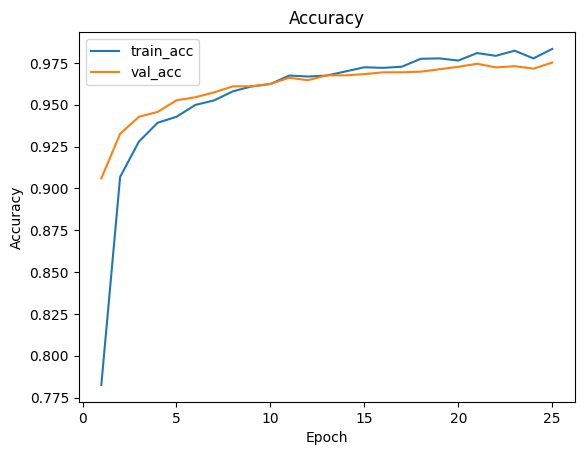

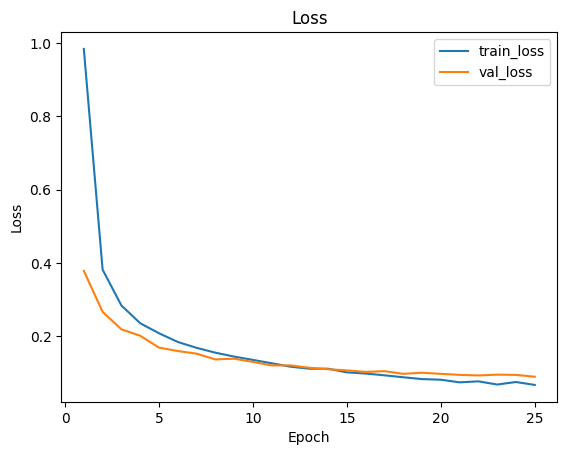

In [ ]:
# Overfitting diagnostics (To be removed)
import numpy as np
import matplotlib.pyplot as plt

# 1) Pull curves from the Keras History
h = history.history
epochs = range(1, len(h["acc"]) + 1)

train_acc = np.array(h["acc"])
val_acc   = np.array(h["val_acc"])
train_loss = np.array(h["loss"])
val_loss   = np.array(h["val_loss"])

# 2) Compute gaps
best_val_idx = int(np.argmax(val_acc))
best_epoch = best_val_idx + 1
gen_gap_at_best = float(train_acc[best_val_idx] - val_acc[best_val_idx])

print(f"Best val epoch: {best_epoch}")
print(f"Train acc @ best val: {train_acc[best_val_idx]:.4f}")
print(f" Val  acc @ best val: {val_acc[best_val_idx]:.4f}")
print(f"Generalization gap (train - val) @ best epoch: {gen_gap_at_best:+.4f}")

# Optional: last-epoch gap (sometimes useful)
last_gap = float(train_acc[-1] - val_acc[-1])
print(f"Last-epoch gap: {last_gap:+.4f}")

# 3) Simple heuristics
def flag(msg): print("⚠️", msg)

if (val_loss.size > 3) and (val_loss[-1] > np.min(val_loss) + 0.02):
    flag("Validation loss has risen from its minimum → possible overfitting.")

if gen_gap_at_best > 0.05:
    flag("Train accuracy is >5% higher than validation at the best epoch → possible overfitting.")

# 4) Plot curves
plt.figure()
plt.plot(epochs, train_acc, label="train_acc")
plt.plot(epochs, val_acc,   label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss,   label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend(); plt.show()